# Install required packages

We need to first install jax package before install the `ARC` package:

In [1]:
!pip install -U "jax[cpu]"

DEPRECATION: Loading egg at /Users/plewis/.local/lib/python3.11/site-packages/linmix-0.1.0.dev1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Install the `ARC` package directly from the [ARC](https://github.com/MarcYin/ARC) GitHub repository:

In [2]:
!pip install https://github.com/MarcYin/ARC/archive/refs/heads/main.zip

DEPRECATION: Loading egg at /Users/plewis/.local/lib/python3.11/site-packages/linmix-0.1.0.dev1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  Using cached https://github.com/MarcYin/ARC/archive/refs/heads/main.zip
  Preparing metadata (setup.py) ... done


Google Earth Engine (GEE) offers a simple and fast way to download Earth Observation data, and the `ARC` package will automatically download Sentinel-2(S2) data from GEE for a given region of interest. Thus, we need to authentificate our GEE account:

In [3]:
import ee

#ee.Authenticate()

## Test NDVI to LAI relationship

Once the installation and configuration finished, we can run a simple test to see if the package is generating reasonable ouputs. Here, a simple NDVI to LAI relationship is checked for `10000` samples, which normally closely related with NDVI saturates when LAI over 3.

Predicting S2 reflectance: 100%|███████████| 300/300 [00:03<00:00, 92.00slice/s]


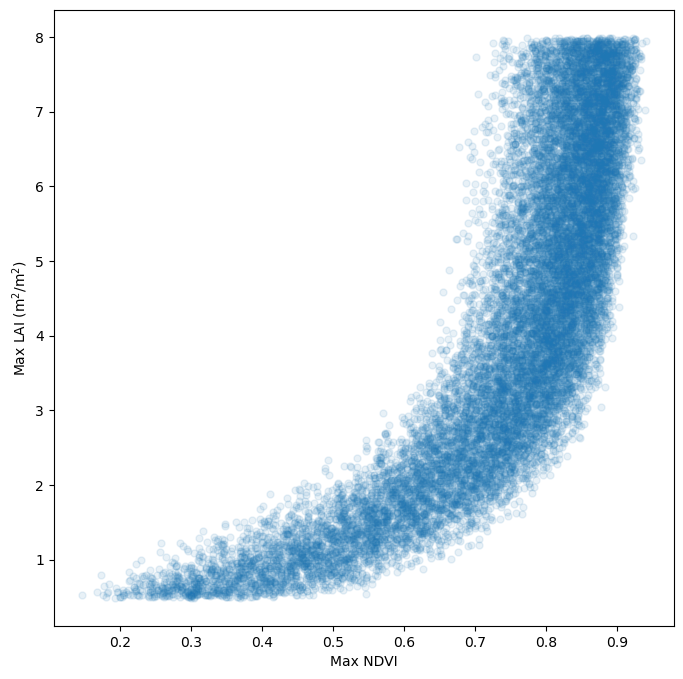

In [4]:
import arc
import numpy as np

doys = np.arange(1, 366, 5)
angs = (
    np.array(
        [
            30,
        ]
        * len(doys)
    ),
    np.array(
        [
            10,
        ]
        * len(doys)
    ),
    np.array(
        [
            120,
        ]
        * len(doys)
    ),
)

num_samples = 10000
start_of_season = 150
growth_season_length = 45
crop_type = "maize"

# Generate reference samples
s2_refs, pheo_samples, bio_samples, orig_bios, soil_samples = arc.generate_arc_refs(
    doys, start_of_season, growth_season_length, num_samples, angs, crop_type
)


# Plot the relationship between maximum NDVI and maximum LAI:

max_lai = np.nanmax(orig_bios[4], axis=0)
ndvi = (s2_refs[7] - s2_refs[3]) / (s2_refs[7] + s2_refs[3])
max_ndvi = np.nanmax(ndvi, axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(max_ndvi, max_lai / 100, "o", ms=5, alpha=0.1)
plt.xlabel("Max NDVI")
plt.ylabel("Max LAI (m$^2$/m$^2$)")
plt.show()

## Test the South Africa ground measurement field

Here, we do a test run over the South Africa ground measurement field in 2022. 

Predicting S2 reflectance: 100%|███████████| 300/300 [00:16<00:00, 17.66slice/s]
/Users/plewis/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


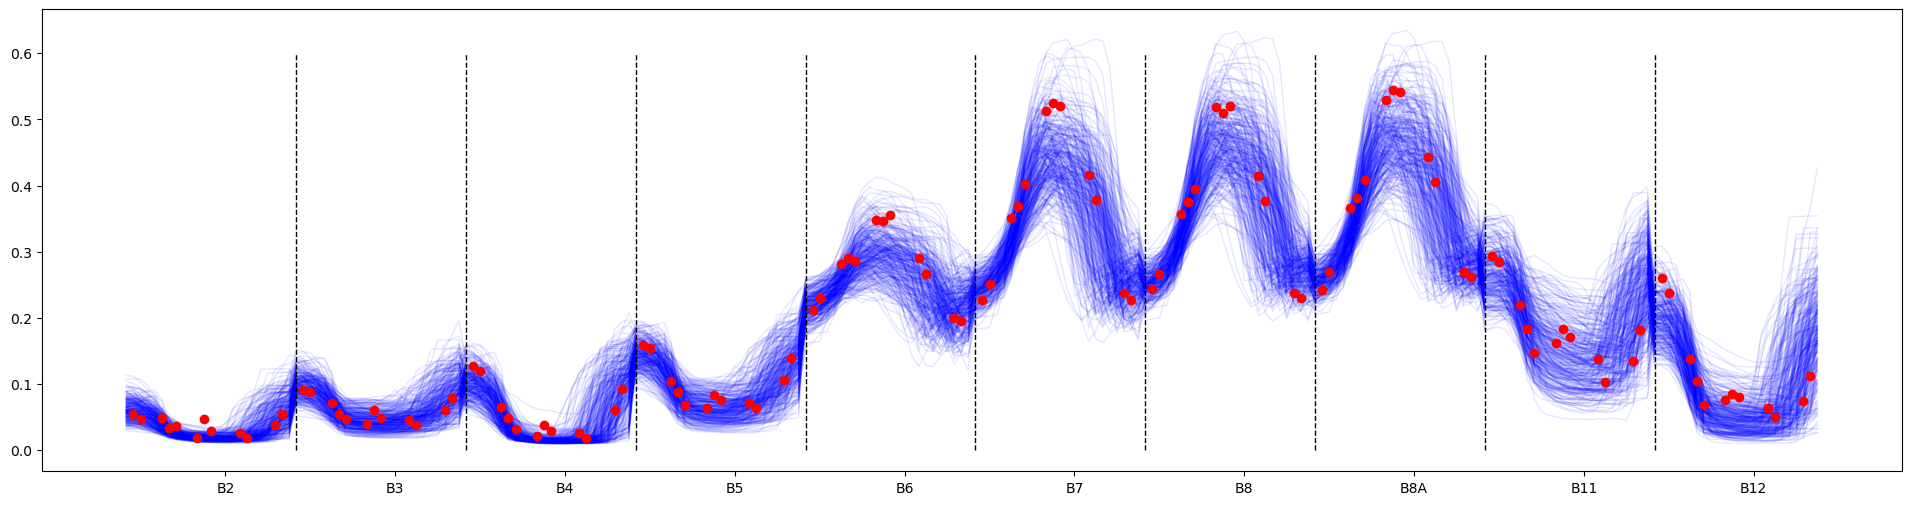

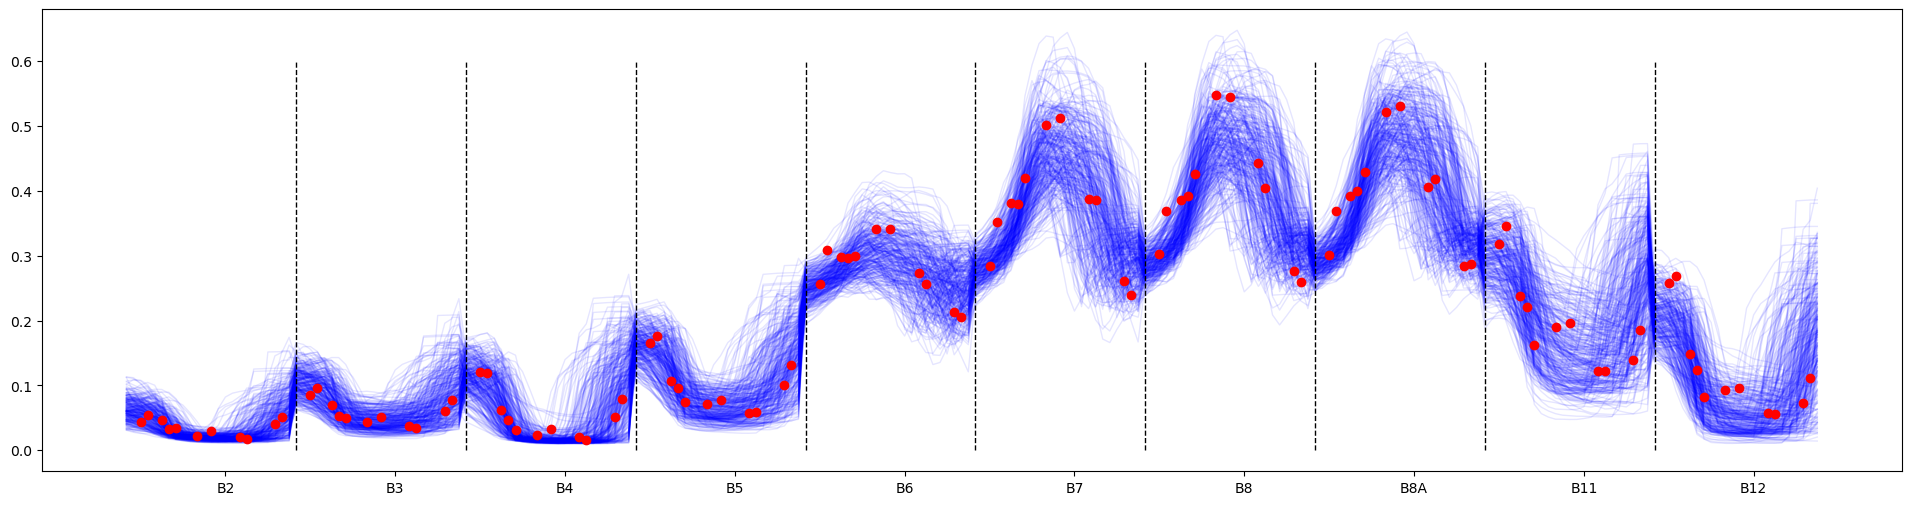

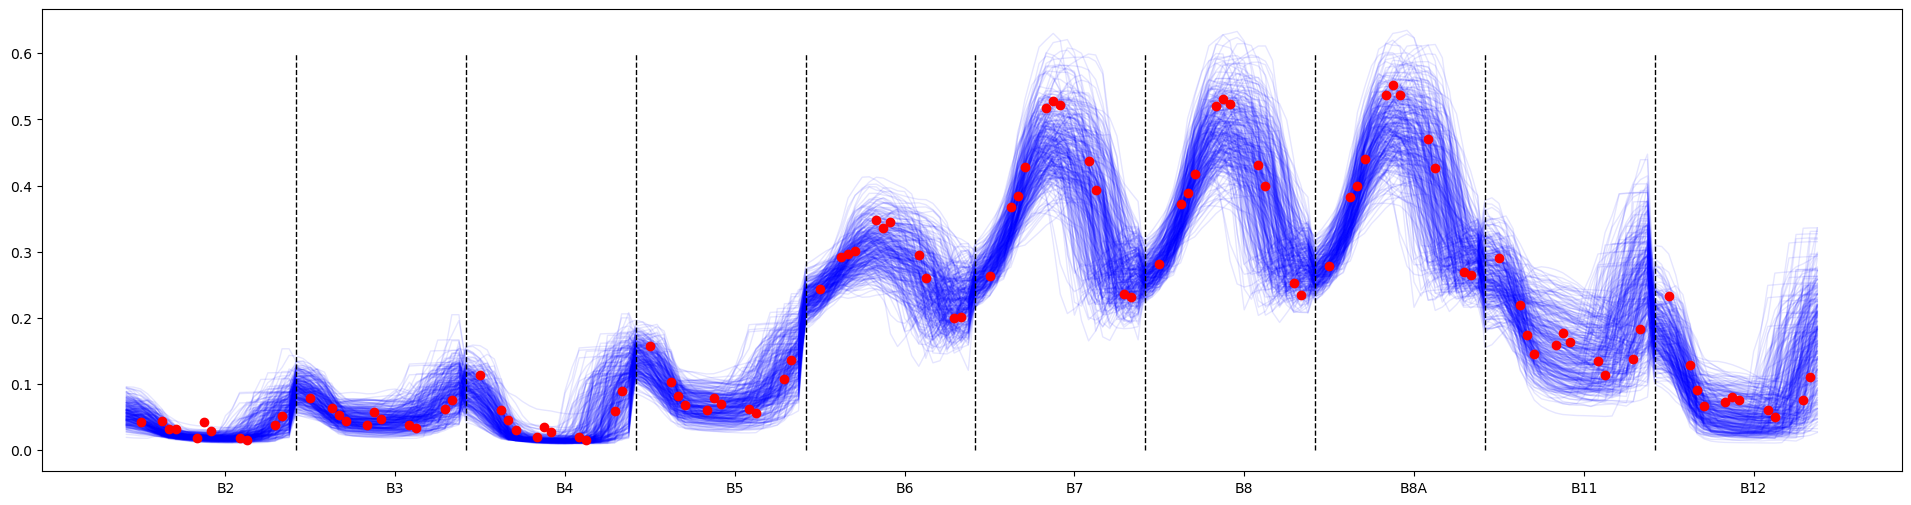

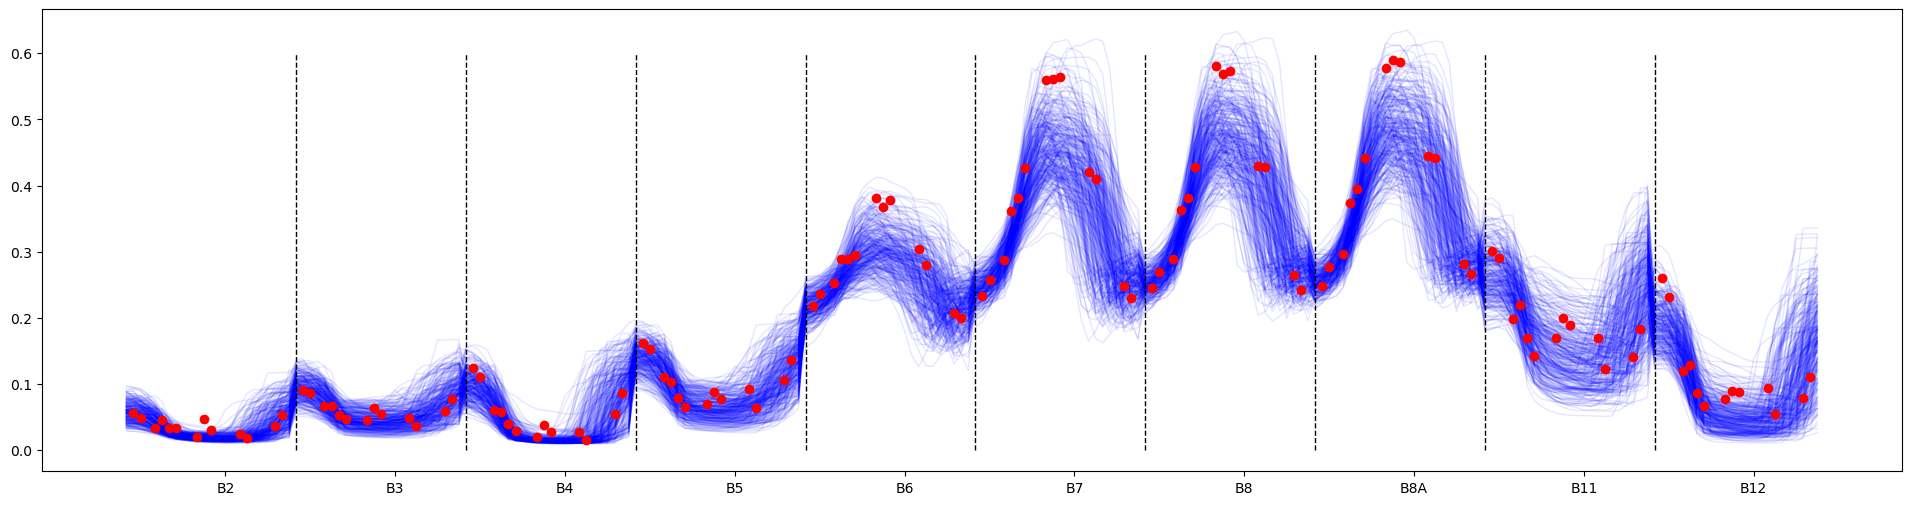

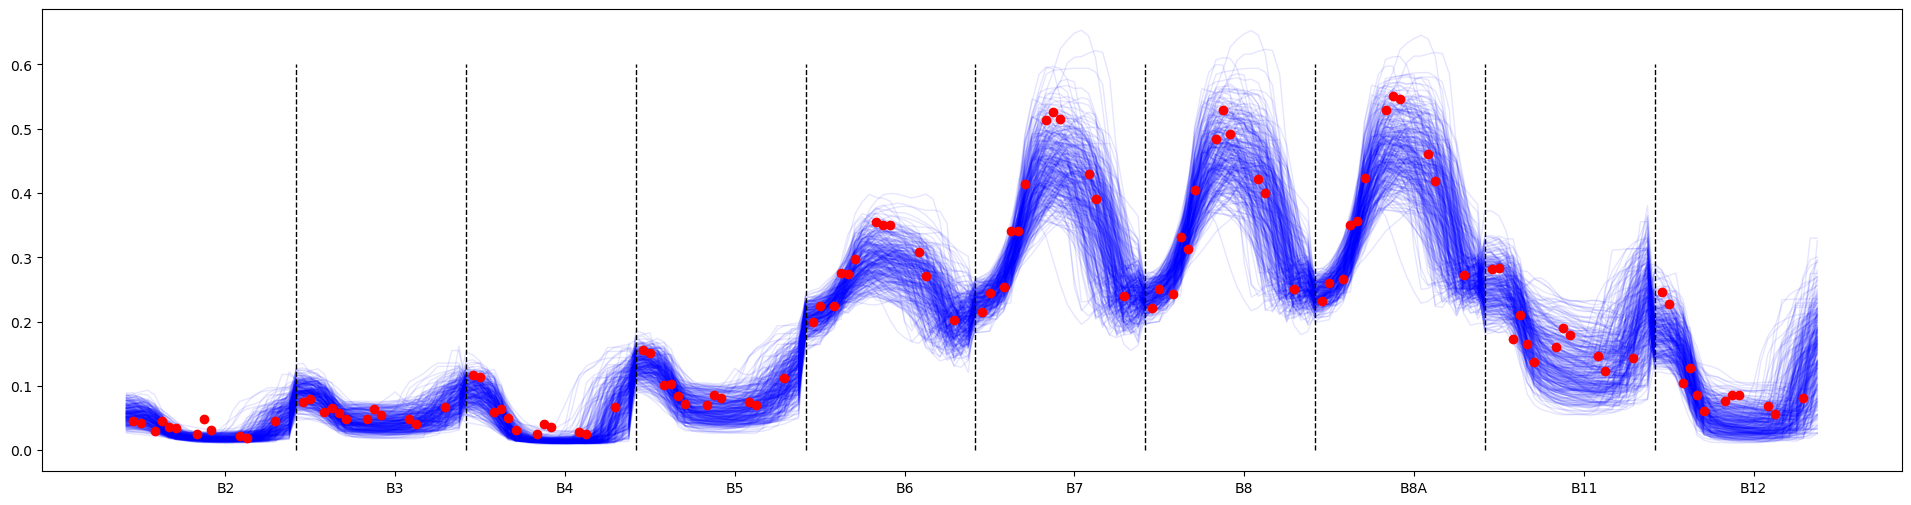

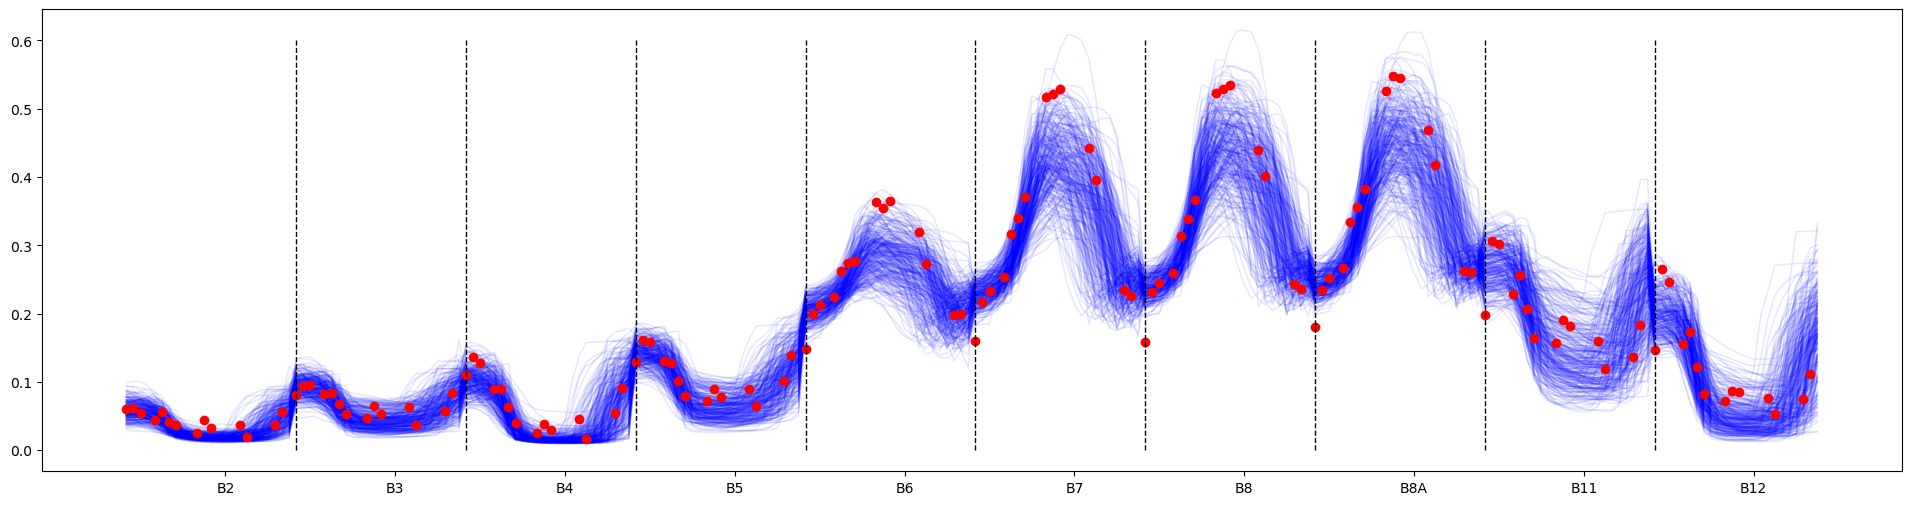

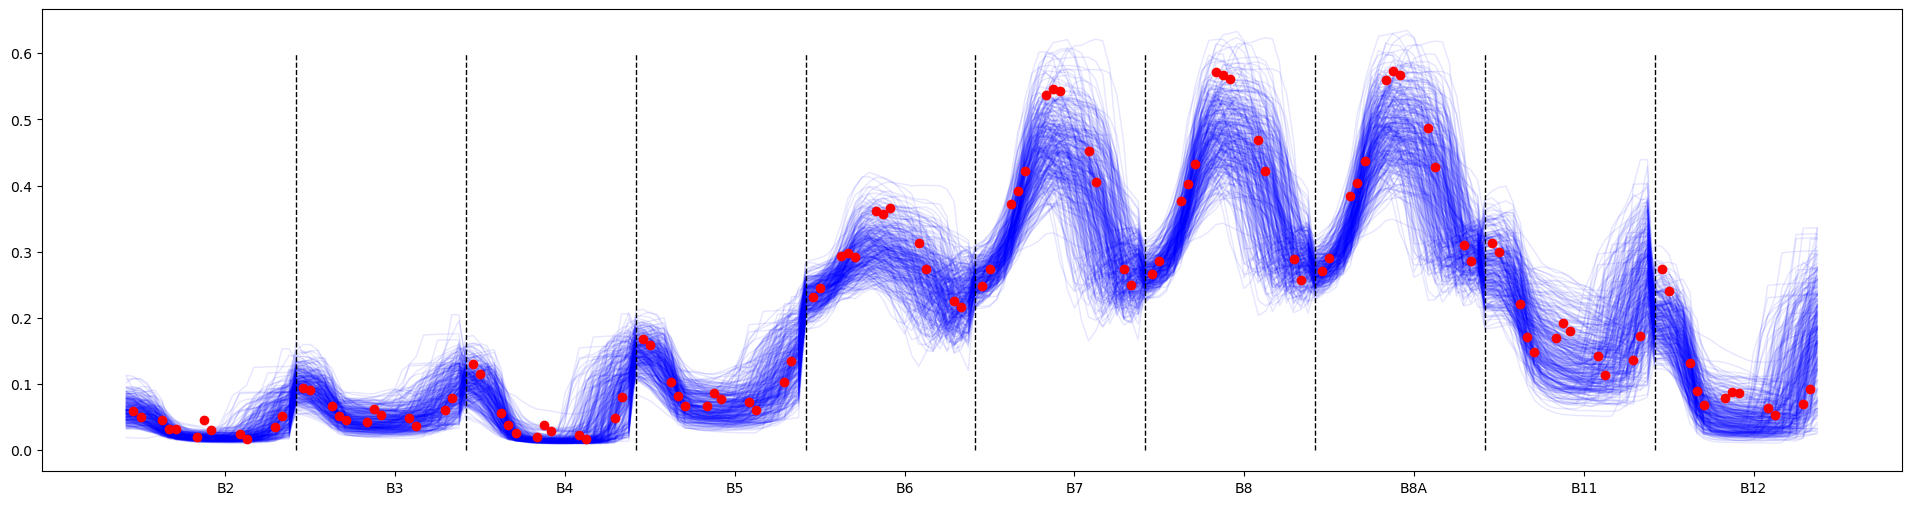

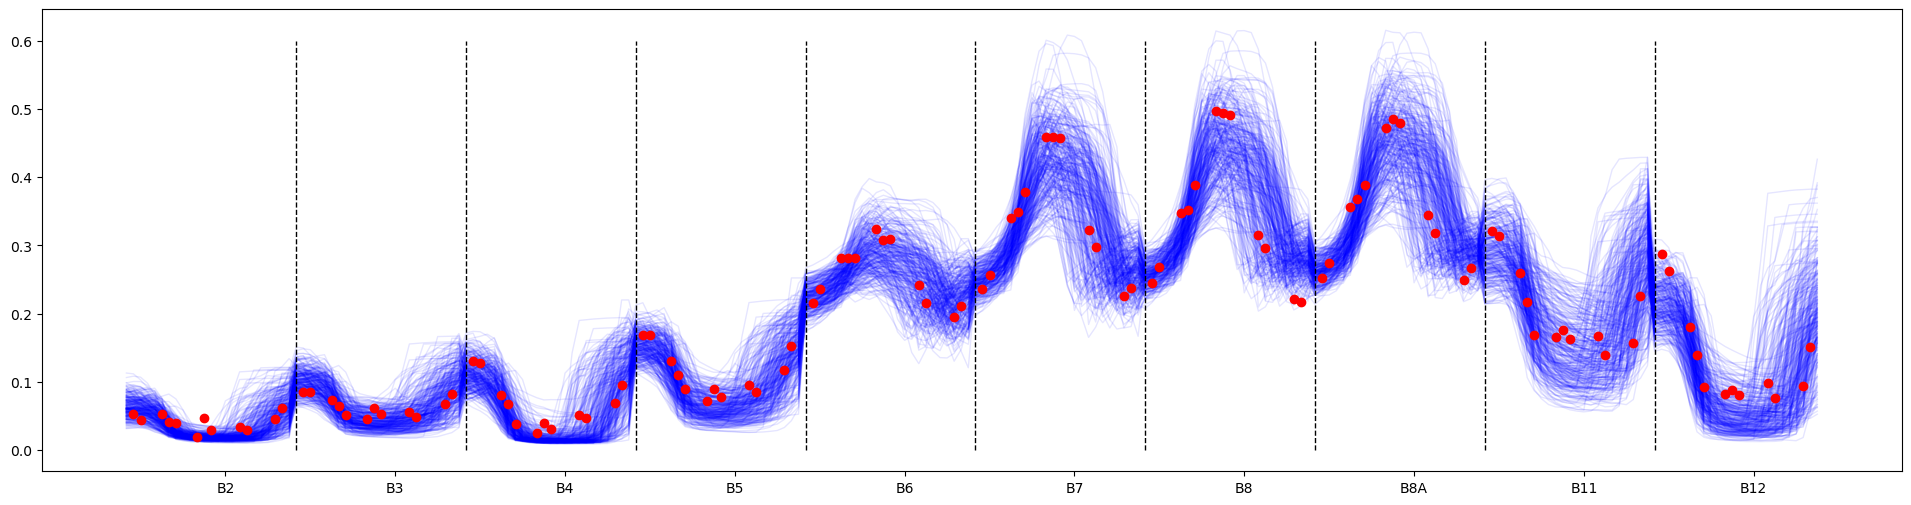

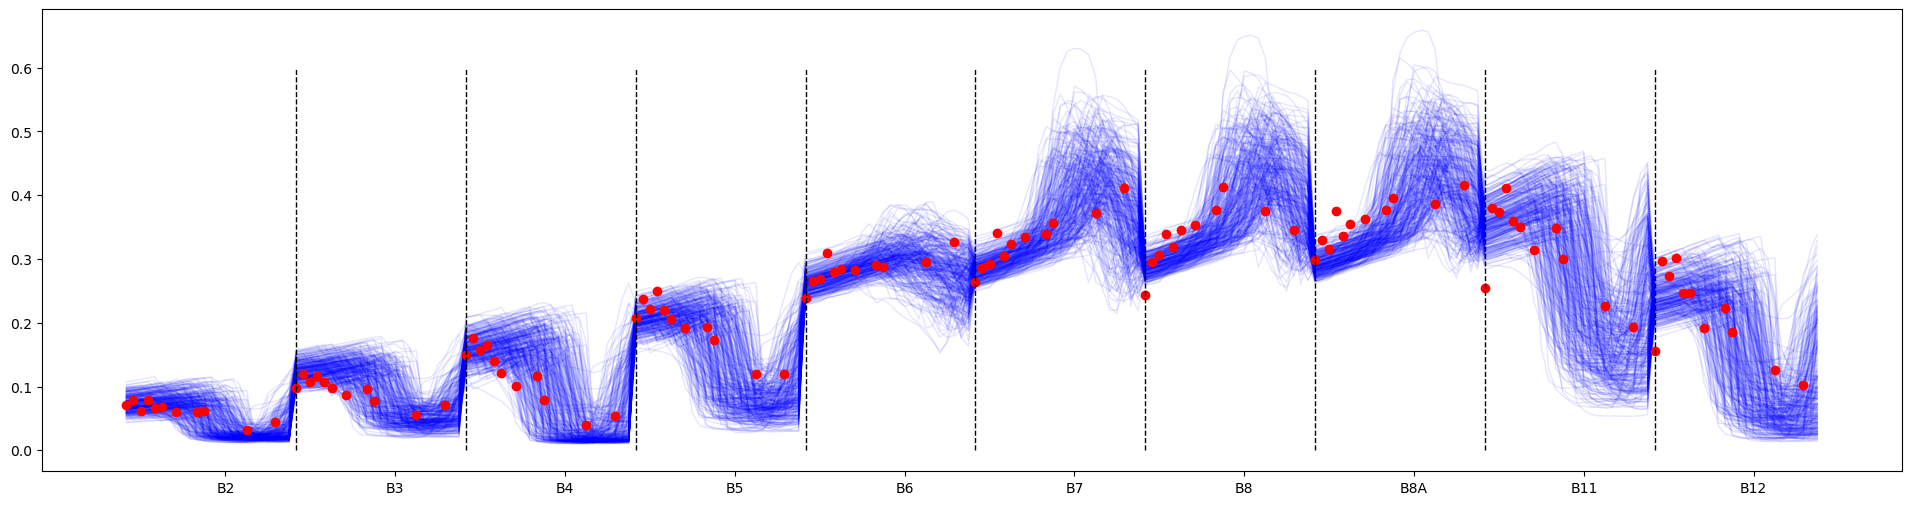

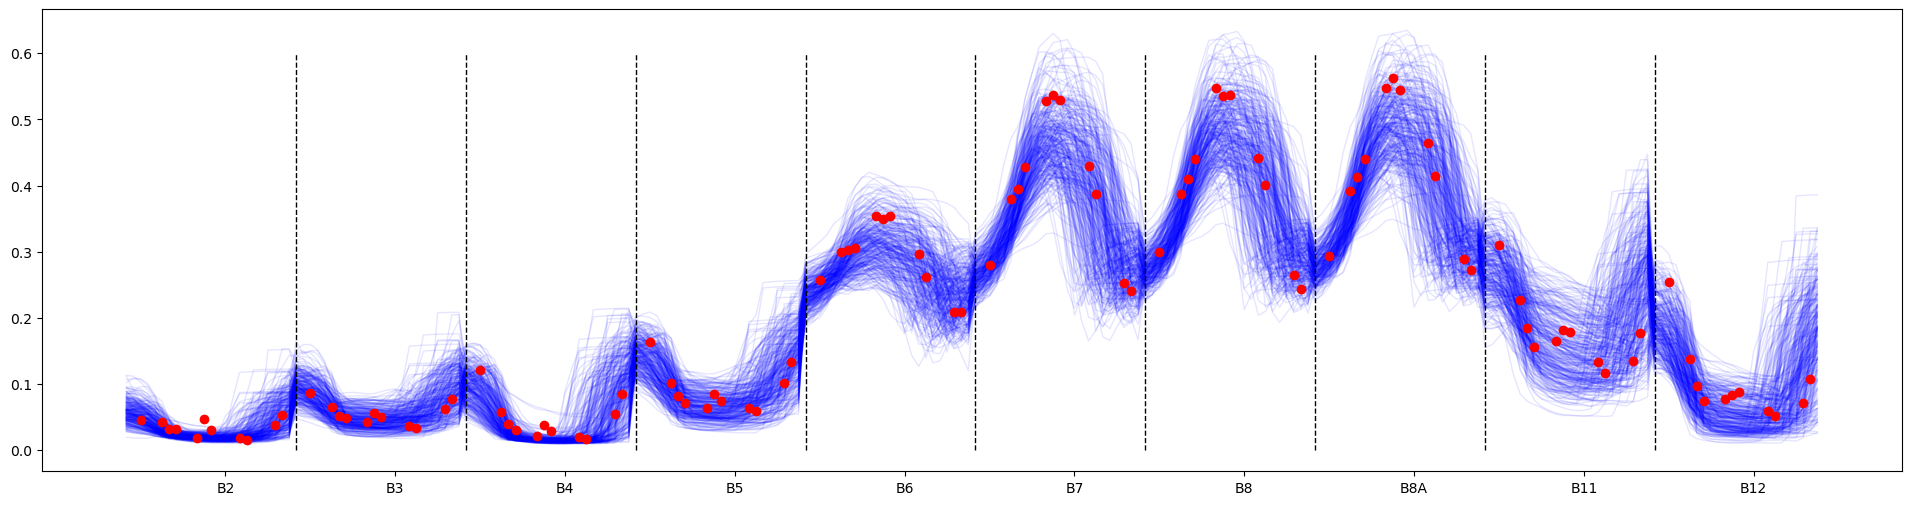

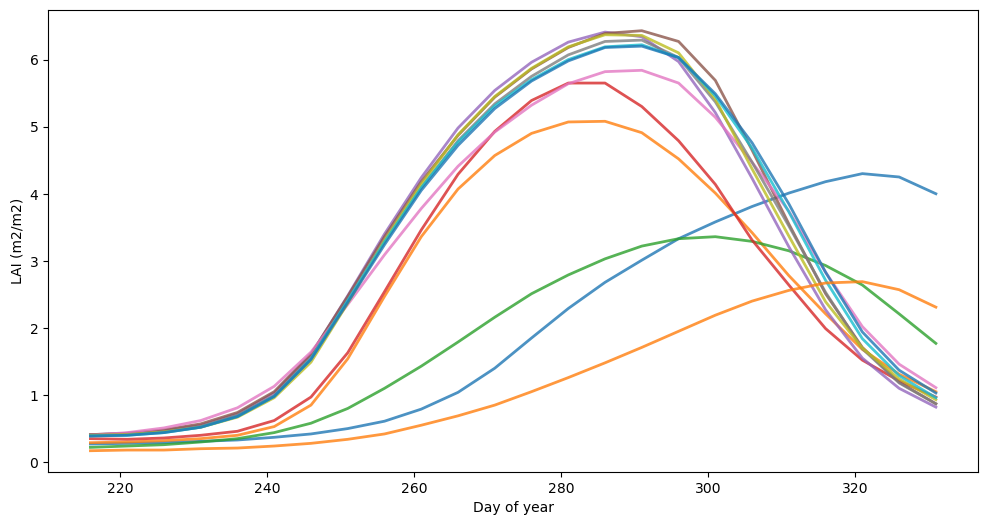

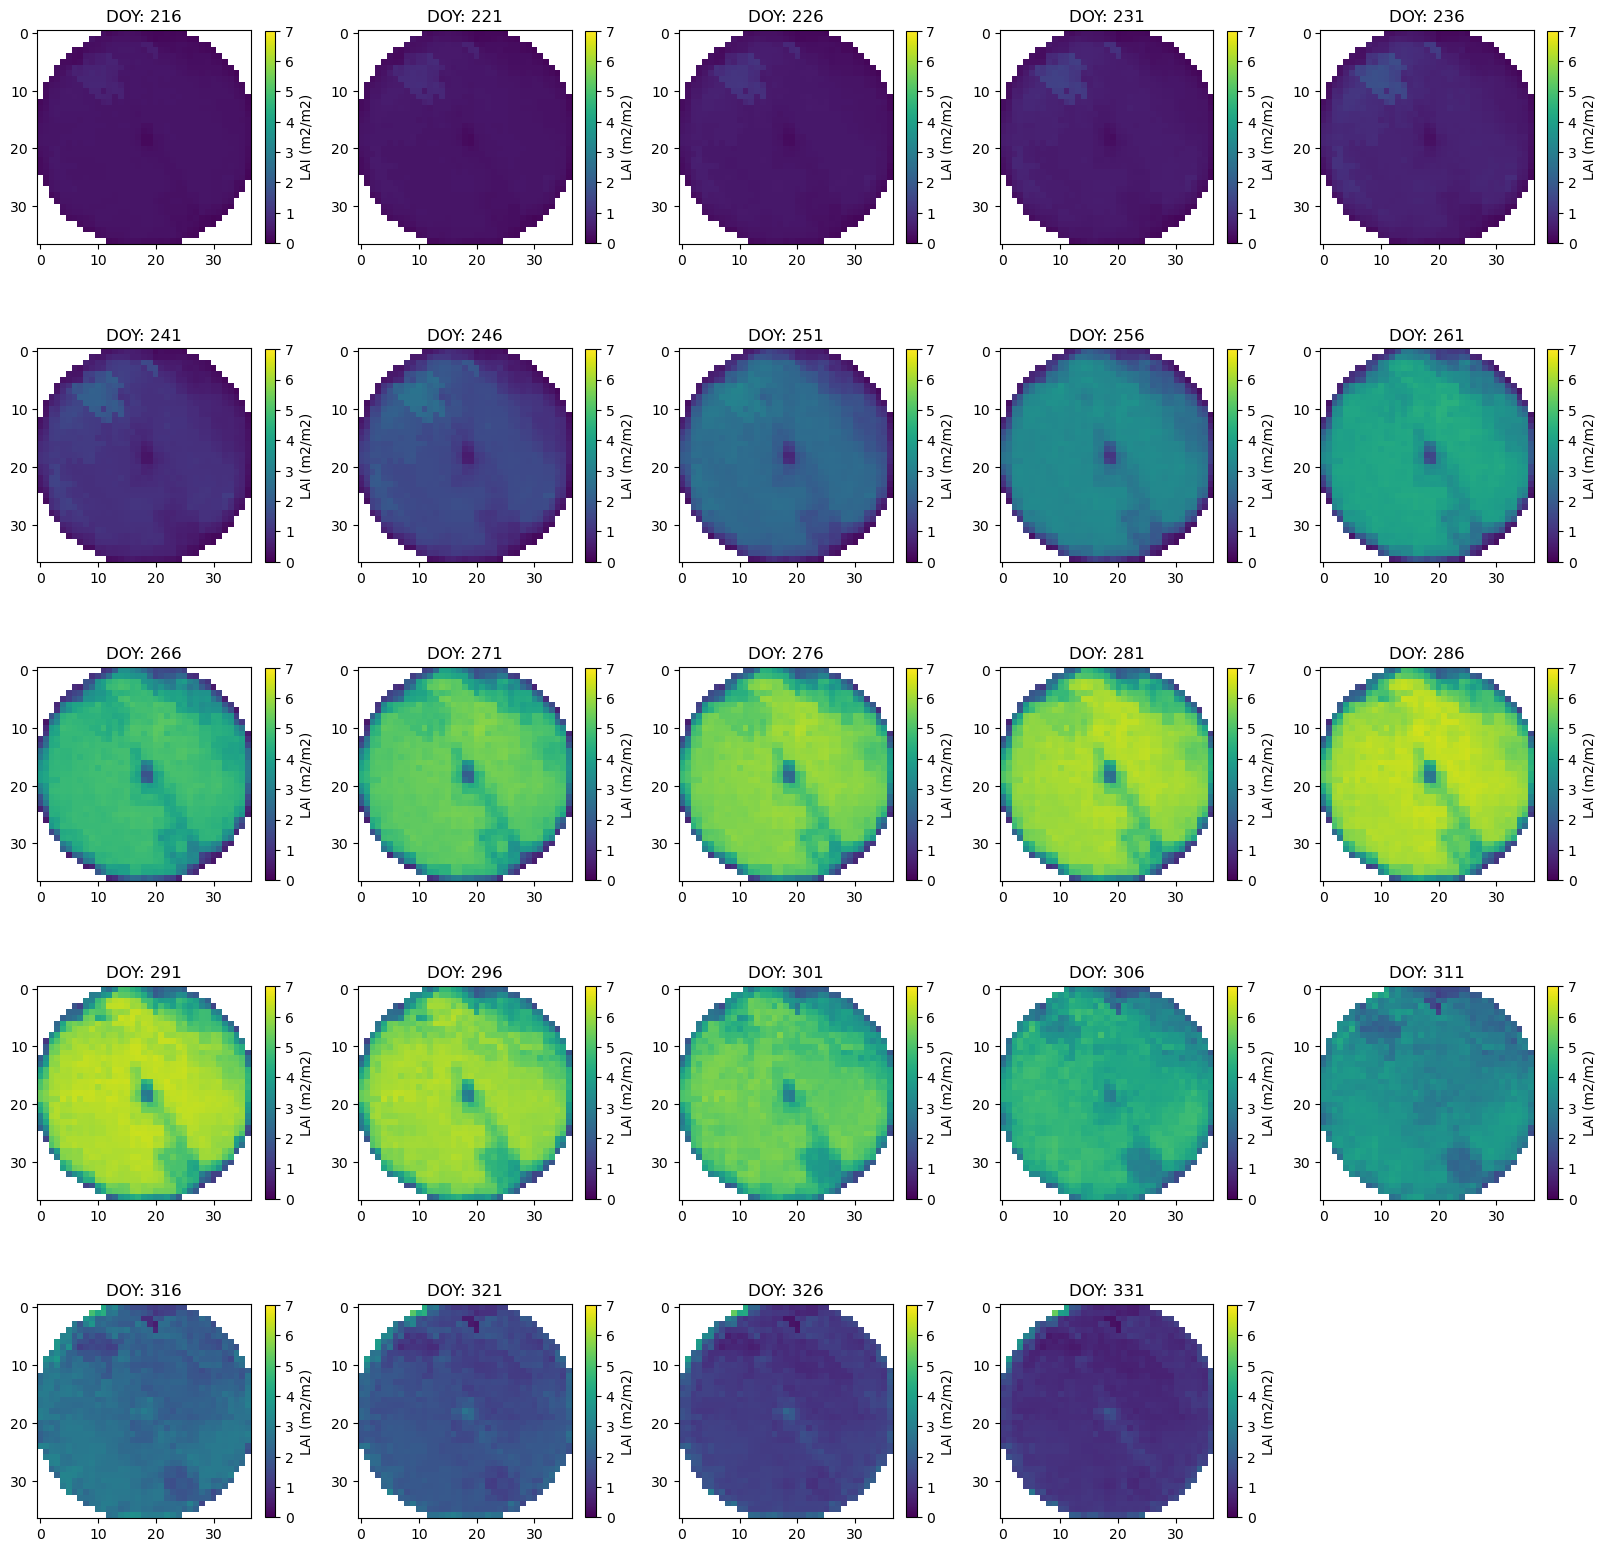

In [6]:
import os
from pathlib import Path

import arc
import matplotlib.pyplot as plt
import numpy as np

# Constants
START_OF_SEASON = 260
CROP_TYPE = "wheat"
NUM_SAMPLES = 200000
GROWTH_SEASON_LENGTH = 45
LAZY_EVALUATION_STEP = 100
ALPHA = 0.8
LINE_WIDTH = 2
start_date = "2022-08-01"
end_date = "2022-11-30"


def main():
    """Main function to execute the Arc field processing and plotting"""

    arc_dir = os.path.dirname(os.path.realpath(arc.__file__))
    geojson_path = f"{arc_dir}/test_data/SF_field.geojson"
    S2_data_folder = Path.home() / f"Downloads/{Path(geojson_path).stem}"
    S2_data_folder.mkdir(parents=True, exist_ok=True)

    scale_data, post_bio_tensor, post_bio_unc_tensor, mask, doys = arc.arc_field(
        start_date,
        end_date,
        geojson_path,
        START_OF_SEASON,
        CROP_TYPE,
        f"{S2_data_folder}/SF_field.npz",
        NUM_SAMPLES,
        GROWTH_SEASON_LENGTH,
        str(S2_data_folder),
        plot=True,
    )

    plot_lai_over_time(doys, post_bio_tensor)
    plot_lai_maps(doys, post_bio_tensor, mask)
    return scale_data, post_bio_tensor, post_bio_unc_tensor, mask, doys


def plot_lai_over_time(doys: np.array, post_bio_tensor: np.array):
    """Plot LAI over time"""

    plt.figure(figsize=(12, 6))
    plt.plot(
        doys,
        post_bio_tensor[
            ::LAZY_EVALUATION_STEP,
            4,
        ].T
        / 100,
        "-",
        lw=LINE_WIDTH,
        alpha=ALPHA,
    )
    plt.ylabel("LAI (m2/m2)")
    plt.xlabel("Day of year")
    plt.show()


def plot_lai_maps(doys: np.array, post_bio_tensor: np.array, mask: np.array):
    """Plot LAI maps"""

    lai = post_bio_tensor[:, 4].T / 100
    nrows = int(len(doys) / 5) + int(len(doys) % 5 > 0)
    fig, axs = plt.subplots(ncols=5, nrows=nrows, figsize=(20, 4 * nrows))
    axs = axs.ravel()

    for i in range(len(doys)):
        lai_map = np.zeros(mask.shape) * np.nan
        lai_map[~mask] = lai[i]
        im = axs[i].imshow(lai_map, vmin=0, vmax=7)
        fig.colorbar(im, ax=axs[i], shrink=0.8, label="LAI (m2/m2)")
        axs[i].set_title("DOY: %d" % doys[i])

    # remove empty plots
    for i in range(len(doys), len(axs)):
        axs[i].axis("off")
    plt.show()


if __name__ == "__main__":
    scale_data, post_bio_tensor, post_bio_unc_tensor, mask, doys = main()

## Ground measurements

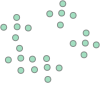

In [7]:
import geojson
from shapely import geometry

features = geojson.load(open('South_Africa_ground_measurements.json', 'r'))['features']
geoms = []
coords = []
for feature in features:
    
    coord = feature['geometry']['coordinates']
    coords.append(coord[:2])
    
    geom = geometry.Point(coord)
    geoms.append(geom)
geometry.GeometryCollection(geoms)

## Transform coordinates

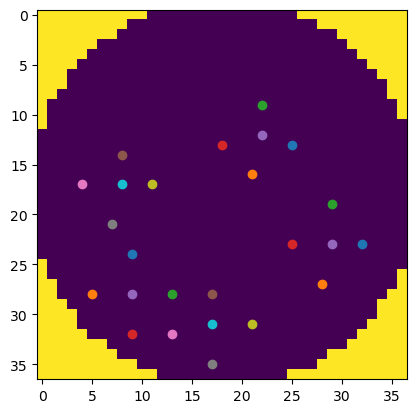

In [8]:
arc_dir = os.path.dirname(os.path.realpath(arc.__file__))
geojson_path = f"{arc_dir}/test_data/SF_field.geojson"
S2_data_folder = Path.home() / f"Downloads/{Path(geojson_path).stem}"
S2_data_folder.mkdir(parents=True, exist_ok=True)
output_file = f"{S2_data_folder}/SF_field.npz"
f = np.load(output_file)

geotransform = tuple(f.f.geotransform.tolist())
crs = str(f.f.crs)

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
Tcoords = [i for i in transformer.itransform(coords)]


Acoords = np.array([[(i[0] - geotransform[0]) / geotransform[1], (i[1] - geotransform[3]) / geotransform[5]] for i in Tcoords]).astype(int)

for i in Acoords:
    plt.plot(i[0],i[1], 'o')
plt.imshow(mask)

### Reconstruct 2D array from the valid pixels

In [9]:
s2_lai = post_bio_tensor[:, 4]
s2_cab = post_bio_tensor[:, 1]

temp = np.zeros(mask.shape + (s2_lai.shape[1], ))
temp[~mask] = s2_lai
s2_lai = temp

temp = np.zeros(mask.shape + (s2_cab.shape[1], ))
temp[~mask] = s2_cab
s2_cab = temp

## Validation

### LAI

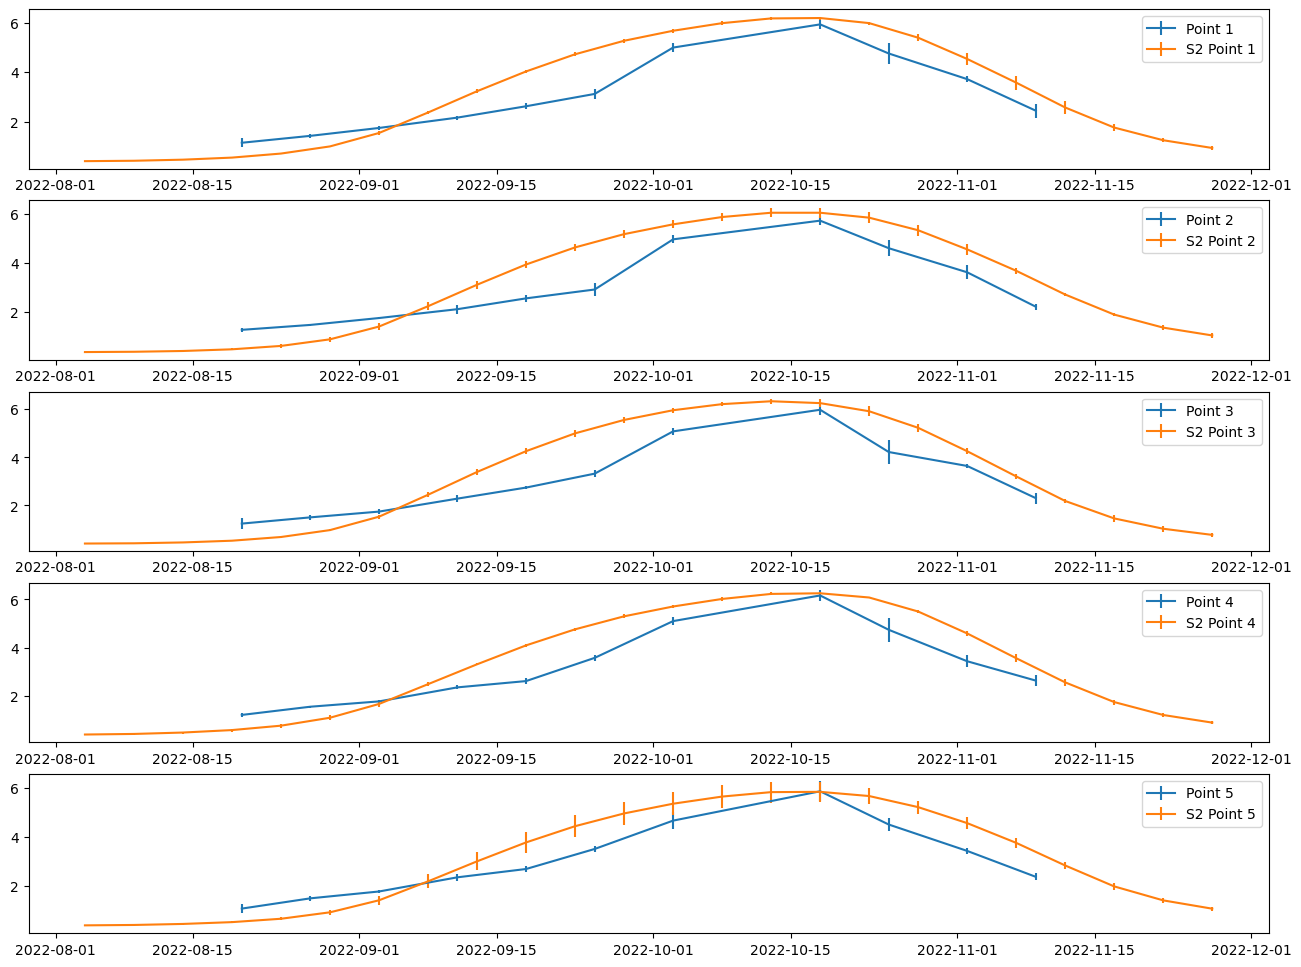

In [10]:
import datetime
import geojson
from shapely import geometry
import pylab as plt

features = geojson.load(open('South_Africa_ground_measurements.json', 'r'))['features']
geoms = []

s2_dates = [datetime.datetime(2022, 1, 1) + datetime.timedelta(days=int(i-1)) for i in doys]

fig, axs = plt.subplots(nrows=5, ncols = 1, figsize=(16, 12))
axs = axs.ravel()

for i in range(1, 6):
    data = []
    sat_data = []
    ax = axs[i-1]
    for j in range(1, 6):
        for feature in features:
            field_id = feature['properties']['field_id']
            if field_id == f'P{i}S{j}':
                coord = feature['geometry']['coordinates'][:2]
                geom = geometry.Point(coord)
                
                Tcoord = transformer.transform(coord[0], coord[1])
                Acoord = (Tcoord[0] - geotransform[0]) / geotransform[1], (Tcoord[1] - geotransform[3]) / geotransform[5]
                Acoord = np.array(Acoord).astype(int)
                sat_data.append(s2_lai[Acoord[1], Acoord[0]] / 100)
                # sat_data.append(s2_cab[Acoord[0], Acoord[1]] / 100)
                
                lai = feature['properties']['LAI_measurement']
                cab = feature['properties']['Cab_measurement']
                
                
                data.append(lai)
                # data.append(cab)
                
                dates = [datetime.datetime.strptime(i, '%Y%m%d') for i in feature['properties']['measurement_dates']]
                # print(field_id)
    val = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    
    sat_val = np.nanmean(sat_data, axis=0)
    sat_std = np.nanstd(sat_data, axis=0)
    
    ax.errorbar(dates, val, std,  label = f'Point {i}')
    ax.errorbar(s2_dates, sat_val, sat_std,  label = f'S2 Point {i}')

    ax.legend()

### Chlorophyll

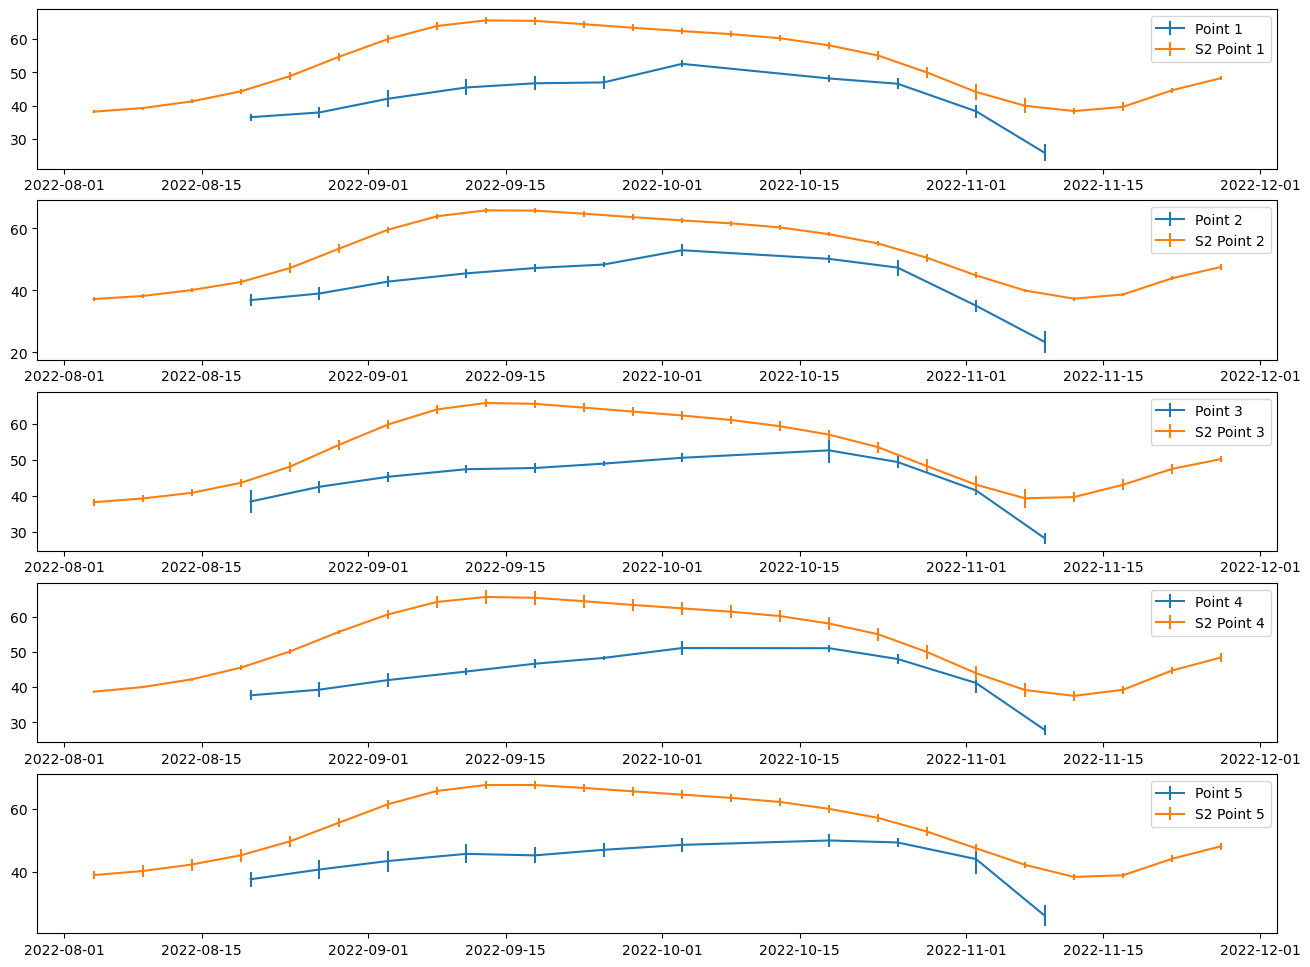

In [11]:
import datetime
import geojson
from shapely import geometry
import pylab as plt

features = geojson.load(open('South_Africa_ground_measurements.json', 'r'))['features']
geoms = []

s2_dates = [datetime.datetime(2022, 1, 1) + datetime.timedelta(days=int(i-1)) for i in doys]

fig, axs = plt.subplots(nrows=5, ncols = 1, figsize=(16, 12))
axs = axs.ravel()

for i in range(1, 6):
    data = []
    sat_data = []
    ax = axs[i-1]
    for j in range(1, 6):
        for feature in features:
            field_id = feature['properties']['field_id']
            if field_id == f'P{i}S{j}':
                coord = feature['geometry']['coordinates'][:2]
                geom = geometry.Point(coord)
                
                Tcoord = transformer.transform(coord[0], coord[1])
                Acoord = (Tcoord[0] - geotransform[0]) / geotransform[1], (Tcoord[1] - geotransform[3]) / geotransform[5]
                Acoord = np.array(Acoord).astype(int)
                # sat_data.append(s2_lai[Acoord[0], Acoord[1]] / 100)
                sat_data.append(s2_cab[Acoord[1], Acoord[0]] / 100)
                
                lai = feature['properties']['LAI_measurement']
                cab = feature['properties']['Cab_measurement']
                
                
                # data.append(lai)
                data.append(cab)
                
                dates = [datetime.datetime.strptime(i, '%Y%m%d') for i in feature['properties']['measurement_dates']]
                # print(field_id)
    val = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    
    sat_val = np.nanmean(sat_data, axis=0)
    sat_std = np.nanstd(sat_data, axis=0)
    
    ax.errorbar(dates, val, std,  label = f'Point {i}')
    ax.errorbar(s2_dates, sat_val, sat_std,  label = f'S2 Point {i}')

    ax.legend()

As we can see from the above results, the satellite retrieval closely follows the ground measurements for the leaf area index. 